<h1 align="center"><font size="6"> Les méthodes de descente de gradient </font> (deuxième partie)</h1>
<hr> 

<h1>Table des matières</h1>

<div class="alert alert-block alert-info" style="margin-top : 20px">
      <ul>
          <li><a href="#prelim">Préliminaires</a></li>
          <li><a href="#Newton">La méthode de Newton</a></li>
          <li><a href="#BFGS">Une méthode de quasi-Newton (BFGS)</a></li>
      </ul>
</div>
<br>
<h>

<a id='prelim'></a>
<h2>Préliminaires</h2>
<hr>

On commence par importer les bibliothèques neecéssaires (_numpy_ et _matplotlib.pyplot_).

On définit aussi deux functions pour la visualisation de: *1/* les lignes de niveaux de la fonction ojectif et *2/* le champ de gradients (pour les fonctions objectifs dépendant de deux variables). 

Il y a aussi un exemple de graphique pour observer la vitesse de convergence des méthodes d'optimisation.

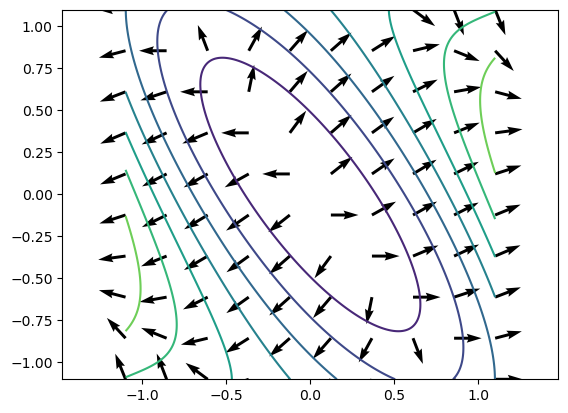

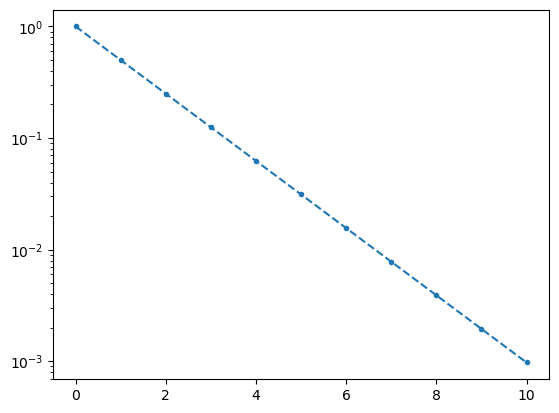

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

def draw_vector_field(F, xmin, xmax, ymin, ymax, N=15):
    X = np.linspace(xmin, xmax, N)  # x coordinates of the grid points
    Y = np.linspace(ymin, ymax, N)  # y coordinates of the grid points
    U, V = F(*np.meshgrid(X, Y))  # vector field
    M = np.hypot(U, V)  # compute the norm of (U,V)
    M[M == 0] = 1  # avoid division by 0
    U /= M  # normalize the u componant
    V /= M  # normalize the v componant
    return plt.quiver(X, Y, U, V, angles='xy')

def level_lines(f, xmin, xmax, ymin, ymax, levels, N=500):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    z = f(*np.meshgrid(x, y))
    level_l = plt.contour(x, y, z, levels=levels)
    #plt.clabel(level_l, levels, fmt='%.1f') 

f = lambda x, y : np.cosh(x)+ np.sin(x + y)**2
df = lambda x, y : np.array([np.sinh(x) + 2*np.cos(x + y)*np.sin(x + y), 2*np.cos(x + y)*np.sin(x + y)])
%matplotlib inline
level_lines(f, -1.1, 1.1, -1.1, 1.1, np.linspace(1, 3, 10))
draw_vector_field(df, -1.1, 1.1, -1.1, 1.1, 10)
plt.axis('equal')
plt.show()

# plot of the values of f along the iterations.
N = 10
F = 2**(-np.linspace(0,N,N+1))
plt.figure()
plt.semilogy(range(N + 1), F, '.', linestyle='dashed')

<a id='Newton'></a>
<h2>La méthode de Newton</h2>
<hr>

On suppose dans ce TP que $f:\mathbb{R}^N\to\mathbb{R}$ est de classe $C^2$ au moins.

La méthode de Newton (ou de Newton-Raphson) est une méthode de descente itérative dans laquelle la direction de descente à l'étape $k$ est choisie de manière à minimiser le développement limité au second ordre de $f$ au point $x^k$, c'est-à-dire
$$
\tag{4}
m_k(d):=f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T D^2 f(x^k) d.
$$
Si la matrice (symétrique) $D^2 f(x^k)$ est définie  positive le minimiseur de $m^k$ existe et est unique. On note $H^k$ l'inverse de $D^2 f(x^k)$, $g^k:=\nabla f(x^k)$ et $d^k$ le minimiseur de (4).

***Question 15.*** Exprimez $d^k$ en fonction de $H^k$ et $g^k$.

___Solution:___ 

Soit $\Lambda>0$. On pose $f_\Lambda(x,y):=(1-x)^2 + \Lambda\,(y-x^2)^2$, pour$(x,y)\in\mathbb{R}^2$.  

__Question 16.__ Calculez $\nabla f_\Lambda(x,y)$. Trouves le(s) minimiseur(s) de $f_\Lambda$. Tracez quelques lignes de niveau de $f_\Lambda$ ainsi que le champ vectoriel renormalisé $(1/|\nabla f_\Lambda|)\nabla f_\Lambda$ pour $\Lambda=100$. Calculez $D^2 f(x,y)$ et son inverse $H_\Lambda(x,y)$.

Les minimiseurs de f sont les point de $\mathbb{R}^2$ vérifiant $\nabla f_{\Lambda}(x,y) = 0$ \
$$	\Longleftrightarrow 2\binom{-((1-x)+2x\Lambda(y-x^2)}{\Lambda(y-x^2)} = \binom{0}{0} $$ \
$$\Longleftrightarrow \binom{x}{y} = \binom{1}{1} $$

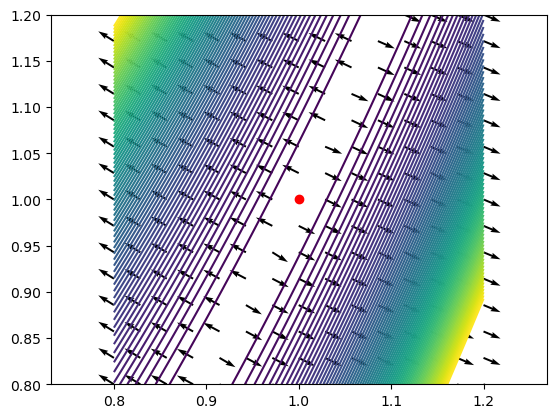

In [5]:
## Solution 
lambd = 100
f = lambda x,y : ( x - 1)**2 + lambd*(y - x**2)**2
df = lambda x,y : np.array([2*(x-1)+4*lambd*x*(x**2-y),2*lambd*(y-x**2)])
ddf = lambda x,y : np.array([[2+4*lambd*(3*x**2-y), -4*lambd*x], [-4*lambd*x, 2*lambd]])
HH = lambda x,y: np.linalg.inv(ddf(x,y))

level_lines(f, .8, 1.2, 0.8, 1.2, np.linspace(0, 30, 80))
draw_vector_field(df, .8, 1.2, 0.8, 1.2, 15)
plt.plot(1,1,'or')
plt.axis('equal')
plt.show()

__Question 17.__ Implémentez la méthode de Newton et appliquez-la à la fonction ci-dessus avec $c=0.1$, $\beta=0.75$ et $x^0=(0,0)$. Représentez les itérations sur un graphique et tracez $\ \log(f_\Lambda(x^k))\ $ en fonction de $k$. Commentez les résultats.

_Indication:_ Testez d'abord l'algorithme sur la fonction quadratique ci-dessous.

In [6]:
# Pour le test
'''
f = lambda x,y : ( x - 1)**2 + 2*(y - 1)**2
df = lambda x,y : np.array([2*(x - 1) , 4*(y - 1)])
#ddf = lambda x,y : np.array([[2  , 0], [0, 2]])
HH = lambda x,y : np.array([[.5, 0], [0, .25]])
'''
pass

Nombre d'itérations pour convergence : 94
Valeur du gradient à la convergence : 1.565251727444346e-08
Valeur du point de convergence : [1. 1.]


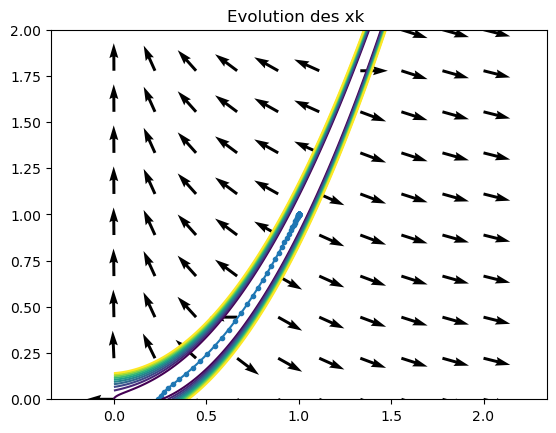

Text(0.5, 1.0, 'Evolution de $\\ \\log(f_\\Lambda(x^k))\\ $ au cours des itérations')

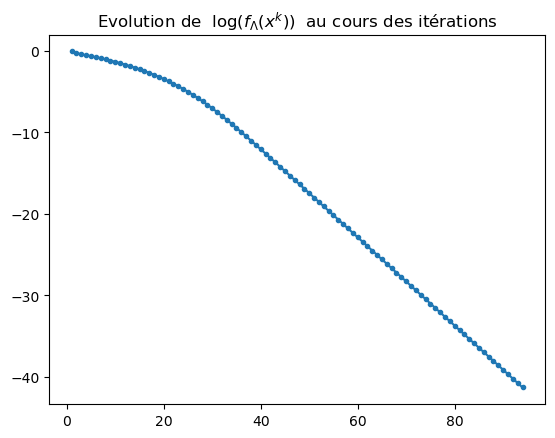

In [7]:
## Parameters
c, beta = .1, .75
epsilon = 1e-8
itermax = 200
iter_ls_max = 40
lambd=100
norm = lambda v : np.linalg.norm(v,2)
tabLogFk = []
tabgk=[]
tabX=[]

## initialisation
f = lambda x,y : ( x - 1)**2 + lambd*(y - x**2)**2
df = lambda x,y : np.array([2*(x-1)+4*lambd*x*(x**2-y),2*lambd*(y-x**2)])
ddf = lambda x,y : np.array([[2+4*lambd*(3*x**2-y), -4*lambd*x], [-4*lambd*x, 2*lambd]])
HH = lambda x,y: np.linalg.inv(ddf(x,y))

## Optmization loop
alpha = 1
iterations=0
# valeurs de départ :
X = np.array([0,0])
x0,y0 = X[0],X[1]
fz=f(x0,y0)
g=df(x0,y0)
normg=norm(g)
normg0=normg

while normg>epsilon*normg0 and iterations<itermax :   # test du critère darrêt 
        # Recherche de la direction d : 
        d=-np.dot(np.linalg.inv(ddf(X[0],X[1] )),g)  # vecteur d de "direction"
        # Recherche du alpha en line-search : 
        iter_ls=0
        Xtemp=X+alpha*d
        new_fz = f(Xtemp[0],Xtemp[1])
        while (new_fz - fz + c*alpha*norm(d)**2 >=0) and iter_ls<=iter_ls_max:
            alpha *= beta
            Xtemp=X+alpha*d
            new_fz = f(Xtemp[0],Xtemp[1])
            iter_ls += 1
        # Mise à jour des variants
        X,fz=X+alpha*d,new_fz
        g,normg=df(X[0],X[1]),norm(g)
        # On conserve pour l'affichage :
        tabgk.append(normg)
        tabLogFk.append(np.log(fz))
        tabX.append(np.array([X[0],X[1]]))
        iterations=iterations+1

print(f"Nombre d'itérations pour convergence : {iterations}")
print(f"Valeur du gradient à la convergence : {normg}")
print(f"Valeur du point de convergence : {X}")

tabIter = np.linspace(1,iterations,iterations)
tabX = np.array(tabX)
tabLogFk = np.array(tabLogFk)
# plot the results
plt.figure()
plt.plot(tabX[:,0],tabX[:,1],'.',linestyle='-')  # Evolution du point de calcul du gradient
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.title("Evolution des xk ")
plt.show()

plt.figure()
plt.plot(tabIter,tabLogFk,'.',linestyle='-')
plt.title("Evolution de $\ \log(f_\Lambda(x^k))\ $ au cours des itérations")


Validation de la méthode de newton

<a id='BFGS'></a>
<h2> Une méthode de quasi-Newton (BFGS)</h2>
<hr>

Lorsque le nombre de paramètres est important comme il est habituel en Machine Learning, le calcul des matrices hessiennes $D^2f(x^k)$ et la résolution des systèmes linéaires $D^2f(x^k) d^k=-g^k$ peuvent être trop coûteux. Cependant, il est souvent encore possible d'obtenir une convergence superlinéaire en remplaçant $[D^2f(x^k)]^{-1}$ par une approximation moins gourmande à calculer qu'on notera $H^k$. Il existe plusieurs algorithmes basés sur cette idée. Nous présentons l'une des plus populaires : la méthode BFGS du nom de leurs découvreurs (Broyden, Fletcher, Goldfarb et Shanno).

__Description de la méthode__ : Supposons qu'à l'étape $k$ nous ayons une approximation définie positive symétrique $H^k$ de $\left[D^2f(x^k)\right]^{-1}$. On note $B^k$ son inverse (qui est une approximation de $D^2f(x^k)$). Comme ci-dessus, nous définissons notre direction de descente $d^k$ comme le minimiseur de
$$
f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T B^k d.
$$
Cela conduit à la formule :
$$
d^k = -\left[B^k\right]^{-1} \nabla f(x^k) = - H^k g^k. 
$$

On cherche ensuite $\alpha_k$ satisfaisant (5) par la méthode de ``backtracking", toujours avec $\alpha=1$ et on pose
$$
x^{k+1} := x^k +\alpha_k d^k.
$$

Maintenant, nous avons besoin de calculer approximation $H^{k+1}$ de $\left[D^2f(x^{k+1})\right]^{-1}$. Pour cela, rappelons que nous voulons
$$
\tilde m_{k+1} (d):= f(x^{k+1}) + g^{k+1}\cdot d +\dfrac 12 d^T B^{k+1} d,
$$
soit une approximation de
$$
\overline m_{k+1}(d):= f(x^{k+1} + d).
$$
Nous avons déjà par construction,
$$
\tilde m_{k+1}(0)=\overline m_{k+1}(0)=f(x^{k+1})\qquad\text{et}\qquad \nabla \tilde m_{k +1}(0)=\nabla \overline m_{k+1}(0)=g(x^{k+1}).
$$
Nous appliquons la nouvelle condition
$$
\nabla m_{k+1}(-\tau_k d^k)=\nabla \overline m_{k+1}(-\tau_k d^k)=g^k.
$$

En notant $a^k:=g^{k+1}-g^k$ et $b^k:=\tau^kd^k=x^{k+1}-x^k$, cela équivaut à $B^{k+1}b^k=a^k$. En supposant que $B^{k+1}$ est inversible, cela équivaut à demander que $H^{k+1}$ soit solution de
$$
\tag{6}
Ha^k=b^k.
$$
Une condition nécessaire et suffisante pour que (6) admette une solution symétrique définie positive $H$ est :
$$
\tag{7}
\left<a^k;b^k\right> >0.
$$

Nous ne voulons pas perdre toute l'information déjà contenue dans $H^k$, donc, en supposant que (7) soit vraie, nous choisissons une solution de (6) aussi proche que possible de $H^k$. Un choix populaire consiste à définir :
$$
\tag{8}
H^{k+1} := \left(I-\rho_k b^k\otimes a^k\right) H^k \left(I-\rho_k a^k\otimes b^k\right) + \rho_k b^k\otimes b^k,\quad\text{ avec }\quad \rho_k:=\dfrac1{\left<a^k;b^k\right>}.
$$

__Question 18.__ Vérifiez que la formule (8) donne bien une solution à (6). Vérifiez que $H^{k+1}$ ainsi définie est une matrice symétrique définie positive 

$H^{k}$ vérifie $H^{k}a^k = b^k$. Ainsi :

$$ H^{k+1}a^k = \left(I-\rho_k b^k\otimes a^k\right) H^k \left(I-\rho_k a^k\otimes b^k\right)a^k + \rho_k b^k\otimes b^k a^k $$\
$$ =  H^k a^k +\rho_k^2 b^k\otimes a^k H^k a^k\otimes b^k a^k - 2H^k\rho_k a^k\otimes b^k + \rho_k b^k\otimes b^k a^k \text{ $\quad \otimes$ est symétrique}$$ \
$$ = b^k + \rho_k^2\frac{1}{\rho_k^2}b^k -2\rho_k\frac{1}{\rho_k}b^k + \rho_k\frac{1}{\rho_k}b^k = b^k$$

Et $H^{k+1}$ vérifie (6). De plus on a   $  \forall a^k \in \mathbb{R}^2, 0 < \left<a^k;b^k\right> = \left<a^k;H^{k+1}a^k\right>$ et $H^{k+1}$ est symétrique donc est une matrice symétrique définie positive.

__Question 19.__ Implémentez la méthode BFGS et appliquez-la à la fonction ci-dessus avec $c = 0.1$, $\beta=0.75$ et $x^0=(0,0)$. Comme premier approximation de $D^2f(x^0)$ on prendra $H^0=I$.

Représentez les itérations sur un graphique et tracez $\ \log(f(x^k))\ $ en fonction de $k$. Observez et commentez.

In [12]:
def approx_H(a,b,H_prec):
    #ro=1/(np.dot(a.T,b))
    #I=np.identity(2)
    return np.dot(np.dot(np.identity(2) - (1/np.dot(a,b.T))*np.dot(b.T, a), H_prec), (np.identity(2) - (1/np.dot(a,b.T))*np.dot(a.T, b))) + (1/np.dot(a,b.T))*np.dot(b.T, b)

Nombre d'itérations pour convergence : 44
Valeur du gradient à la convergence : 8.677328323617452e-09
Valeur du point de convergence : [1. 1.]


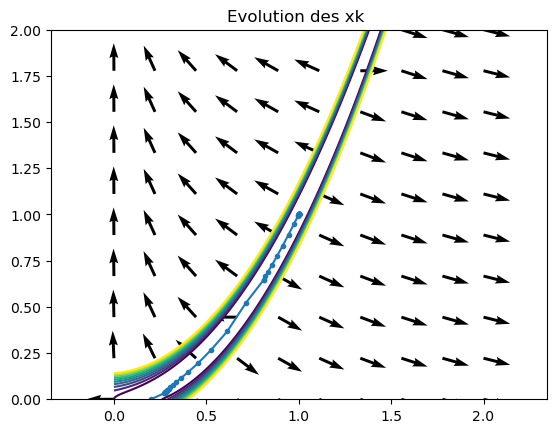

Text(0.5, 1.0, 'Evolution de ||Happrox-Htrue|| au cours des itérations')

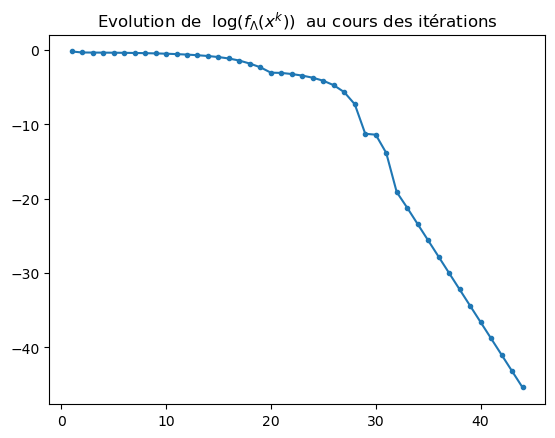

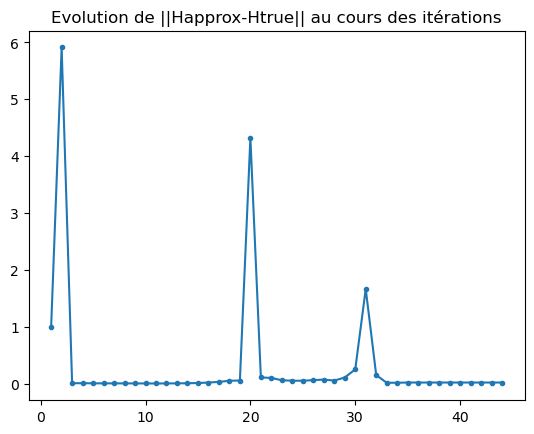

In [14]:
## Solution

## Parameters
c, beta = .1, .75
epsilon = 1e-8
itermax = 300
iter_ls_max = 40
lambd=100
norm = lambda v : np.linalg.norm(v,2)
tabLogFk = []
tabgk=[]
tabX=[]
tabH=[]
##
np.set_printoptions(precision=3)
np.set_printoptions(suppress="True")



## initialisation
f = lambda x,y : ( x - 1)**2 + lambd*(y - x**2)**2
df = lambda x,y : np.array([2*(x-1)+4*lambd*x*(x**2-y),2*lambd*(y-x**2)])
ddf = lambda x,y : np.array([[2+4*lambd*(3*x**2-y), -4*lambd*x], [-4*lambd*x, 2*lambd]])
HH = lambda x,y: np.linalg.inv(ddf(x,y))

## Optmization loop
X = np.array([0,0])
x0,y0 = X[0],X[1]

alpha = 1 ; iterations=0
# valeurs de départ :
fz=f(x0,y0);g=df(x0,y0)
normg=norm(g);normg0=normg
H=np.identity(2)             # Initialisation de H
#X_prec,g_prec=X,g   # On gardera en mémoire l'itération précédente


while normg>epsilon*normg0 and iterations<itermax :   # test du critère darrêt
    # Recherche de la direction d :
    d=-np.dot(H,g)
    tabH.append(norm(H-HH(X[0],X[1])))
    # Recherche du alpha en line-search :
    iter_ls=0
    Xtemp=X+alpha*d
    new_fz = f(Xtemp[0],Xtemp[1])
    while (new_fz - fz + c*alpha*norm(d)**2 >=0) and iter_ls<=iter_ls_max:
        alpha *= beta
        Xtemp=X+alpha*d
        new_fz = f(Xtemp[0],Xtemp[1])
        iter_ls += 1

    # Mise à jour des variants
    X_t=X
    X,fz=X+alpha*d,new_fz
    a_k=np.array([df(X[0], X[1]) - g])
    b_k=np.array([X-X_t])
    g,normg=df(X[0],X[1]),norm(g)

    # Calcul du H suivant :
    H=approx_H(a_k,b_k,H)

    alpha /= beta
    # On conserve pour l'affichage :
    tabgk.append(normg)
    tabLogFk.append(np.log(fz))
    tabX.append(np.array([X[0],X[1]]))
    iterations=iterations+1

print(f"Nombre d'itérations pour convergence : {iterations}")
print(f"Valeur du gradient à la convergence : {normg}")
print(f"Valeur du point de convergence : {X}")

tabIter = np.linspace(1,iterations,iterations)
tabX = np.array(tabX)
tabLogFk = np.array(tabLogFk)
# plot the results
plt.figure()
plt.plot(tabX[:,0],tabX[:,1],'.',linestyle='-')  # Evolution du point de calcul du gradient
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.title("Evolution des xk ")
plt.show()

plt.figure()
plt.plot(tabIter,tabLogFk,'.',linestyle='-')
plt.title("Evolution de $\ \log(f_\Lambda(x^k))\ $ au cours des itérations")

plt.figure()
plt.plot(tabIter,tabH,'.',linestyle='-')
plt.title("Evolution de ||Happrox-Htrue|| au cours des itérations")


# plot of the values of ||Happrox-Htrue|| along the iterations.


__Question 20.__ Est-ce que $H^k$ converge vers $[D^2 f(x^*)]^{-1}$ ?

XXXX